參考資料：
1. AE in keras: https://blog.keras.io/building-autoencoders-in-keras.html
- Autoencoder 自编码:https://morvanzhou.github.io/tutorials/machine-learning/keras/2-6-autoencoder/
- https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
- http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_psnr
- http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim

In [1]:
import time #時間計算

In [2]:
_startTime = time.time()

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from cv2 import imwrite # 圖片輸出用

In [4]:
# import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
# from keras import backend as K

E:\Anaconda3\envs\TF-Ke\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras.models import load_model

In [6]:
# 結果運算用
from skimage.measure import compare_psnr, compare_ssim 

##### 函數 - 測試用

In [7]:
def CheckType(intVar):
    print("max:",   intVar.max())
    print("min:",   intVar.min())
    print("shape:", intVar.shape)
    print("type:",  intVar.dtype)
    return

##### 函數 - 輸出用

In [8]:
def ResultImgShow(inputImg, modelName, strImgLabel = "TMP"):
    # 輸出參數設置
    img_amount = inputImg.shape[0]
    cols_output = 50
    rows_output = img_amount // cols_output
    if rows_output < 3:
        cols_output = 10
        rows_output = img_amount // cols_output
        if rows_output < 3:
            cols_output = 5
            rows_output = img_amount // cols_output
    if rows_output > cols_output:
        rows_output = cols_output
    # 輸出設置
    img_h = inputImg[0]
    for i in range(1, cols_output):
        img_tmp = inputImg[i]
        img_h = np.hstack((img_h, img_tmp))
    img_v = img_h.copy()
    for j in range(1, rows_output):
        img_h = inputImg[j * cols_output]
        for i in range(1, cols_output):
            img_tmp = inputImg[j * cols_output + i]
            img_h = np.hstack((img_h, img_tmp))
        img_v = np.vstack((img_v, img_h))
        
        
    # 顯示 與 存取
    imwrite(modelName.split(".")[0] +"_"+ strImgLabel+ ".png", img_v)
    plt.imshow(img_v, cmap = "gray")
#     plt.savefig(model_name.split(".")[0] +"_"+ strImgLabel+ ".png")
    plt.show()
    plt.close()
    return

In [9]:
def PSNR_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    psnrSum_test = 0
    for i in range(testData.shape[0]):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        psnrTmp = float(compare_psnr(groundTruth, predictResult))
        psnrSum_test += psnrTmp
    psnrSum_test /= testData.shape[0]
#     print("TEST" if boolTest else "TRAIN" ,"PSNR:", psnrSum_test)
    print(strImgLabel, "PSNR:", psnrSum_test)
    return psnrSum_test

In [10]:
def SSIM_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    ssimSum_test = 0
    for i in range(testData.shape[0]):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        ssimTmp = float(compare_ssim(groundTruth, predictResult))
        ssimSum_test += ssimTmp
    ssimSum_test /= testData.shape[0]
    print(strImgLabel, "SSIM:", ssimSum_test)
    return ssimSum_test

In [11]:
def DataPreProcess(inputData, img_rows = 28, img_cols = 28):
    outputData = inputData.reshape(inputData.shape[0], img_rows * img_cols)
    outputData = outputData.astype('float32') /255 -0.5
#     outputData *= 2
    return outputData

In [12]:
def DataRecovery(inputData, img_rows = 28, img_cols = 28):
    outputData = ((inputData /2)+0.5) * 255
    outputData = outputData.reshape((outputData.shape[0], img_rows, img_cols))
    outputData = outputData.astype('uint8')
    return outputData

# 主程式

#### 參數設置

In [13]:
outputFolder = "output_1212/"

In [14]:
batch_size = 128
# num_classes = 10
epochs = 500
# input image dimensions
img_rows, img_cols = 28, 28

In [15]:
# model_name_complex = "model_complex"+"e"+str(epochs)+"_b"+str(batch_size)+".h5"
model_name_simple  = "model_simple" +"e"+str(epochs)+"_b"+str(batch_size)+".h5"

##### 讀取資料
- 利用完整沒雜訊的資料進行訓練 。
- 只取用圖像，不取標籤。

In [16]:
dataSetName = "mnist.npz"
f = np.load(dataSetName)
x_train_org, x_test_org = f['x_train'], f['x_test']
del f

In [17]:
x_train_org = DataPreProcess(x_train_org)
print(x_train_org.shape[0], 'train samples', "in", x_train_org.shape)
# x_test = DataPreProcess(x_test)
# print(x_test.shape[0], 'tset samples', "in", x_test.shape)

60000 train samples in (60000, 784)


### 模組架設 - 簡單版

In [18]:
## 法 2 - 比較有效率
input_img = Input(shape=(784,))
# encoder layers
encoder_output = Dense(50)(input_img)
# decoder layers
decoded = Dense(784, activation='tanh')(encoder_output)
# construct the autoencoder model
autoencoder_simple = Model(input=input_img, output=decoded)

E:\Anaconda3\envs\TF-Ke\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


#### 模組 - 簡介

In [19]:
autoencoder_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               39984     
Total params: 79,234
Trainable params: 79,234
Non-trainable params: 0
_________________________________________________________________


#### 模組 - 架設

In [20]:
autoencoder_simple.compile(optimizer='adam', loss='mse')

#### 模組 - 訓練
用完整圖片訓練，完整圖片比對

In [21]:
history_simple = autoencoder_simple.fit(x_train_org, x_train_org, # 訓練資料、結果比對資料
                    batch_size=batch_size, #
                    epochs=epochs)

Epoch 1/500
60000/60000 [==============================] - 3s 55us/step - loss: 0.0356
Epoch 2/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0140
Epoch 3/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0115
Epoch 4/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.0109
Epoch 5/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0108
Epoch 6/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0107
Epoch 7/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.0107
Epoch 8/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0107
Epoch 9/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0107
Epoch 10/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0107
Epoch 11/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.0107
Epoch 12/500
60000/60000 [===============

60000/60000 [==============================] - 4s 71us/step - loss: 0.0104
Epoch 95/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0104
Epoch 96/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0104
Epoch 97/500
60000/60000 [==============================] - 4s 71us/step - loss: 0.0104
Epoch 98/500
60000/60000 [==============================] - 7s 109us/step - loss: 0.0104
Epoch 99/500
60000/60000 [==============================] - 2s 37us/step - loss: 0.0104
Epoch 100/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0104
Epoch 101/500
60000/60000 [==============================] - 3s 45us/step - loss: 0.0104
Epoch 102/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0104
Epoch 103/500
60000/60000 [==============================] - 3s 57us/step - loss: 0.0104
Epoch 104/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0104
Epoch 105/500
60000/60000 [============

60000/60000 [==============================] - 4s 63us/step - loss: 0.0104
Epoch 186/500
60000/60000 [==============================] - 5s 89us/step - loss: 0.0104
Epoch 187/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.0104
Epoch 188/500
60000/60000 [==============================] - 3s 56us/step - loss: 0.0104
Epoch 189/500
60000/60000 [==============================] - 5s 90us/step - loss: 0.0104
Epoch 190/500
60000/60000 [==============================] - 2s 29us/step - loss: 0.0104
Epoch 191/500
60000/60000 [==============================] - 2s 40us/step - loss: 0.0104
Epoch 192/500
60000/60000 [==============================] - 6s 95us/step - loss: 0.0104
Epoch 193/500
60000/60000 [==============================] - 3s 43us/step - loss: 0.0104
Epoch 194/500
60000/60000 [==============================] - 2s 28us/step - loss: 0.0104
Epoch 195/500
60000/60000 [==============================] - 5s 82us/step - loss: 0.0104
Epoch 196/500
60000/60000 [========

60000/60000 [==============================] - 2s 34us/step - loss: 0.0104
Epoch 277/500
60000/60000 [==============================] - 2s 34us/step - loss: 0.0104
Epoch 278/500
60000/60000 [==============================] - 2s 35us/step - loss: 0.0104
Epoch 279/500
60000/60000 [==============================] - 2s 34us/step - loss: 0.0104
Epoch 280/500
60000/60000 [==============================] - 2s 35us/step - loss: 0.0104
Epoch 281/500
60000/60000 [==============================] - 2s 35us/step - loss: 0.0104
Epoch 282/500
60000/60000 [==============================] - 2s 34us/step - loss: 0.0104
Epoch 283/500
60000/60000 [==============================] - 2s 35us/step - loss: 0.0104
Epoch 284/500
60000/60000 [==============================] - 2s 34us/step - loss: 0.0104
Epoch 285/500
60000/60000 [==============================] - 2s 34us/step - loss: 0.0104
Epoch 286/500
60000/60000 [==============================] - 2s 36us/step - loss: 0.0104
Epoch 287/500
60000/60000 [========

Epoch 368/500
60000/60000 [==============================] - 7s 123us/step - loss: 0.0104
Epoch 369/500
60000/60000 [==============================] - 7s 120us/step - loss: 0.0104
Epoch 370/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0104
Epoch 371/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0104
Epoch 372/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0104
Epoch 373/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0104
Epoch 374/500
60000/60000 [==============================] - 2s 33us/step - loss: 0.0104
Epoch 375/500
60000/60000 [==============================] - 7s 120us/step - loss: 0.0104
Epoch 376/500
60000/60000 [==============================] - 7s 113us/step - loss: 0.0104
Epoch 377/500
60000/60000 [==============================] - 3s 50us/step - loss: 0.0104
Epoch 378/500
60000/60000 [==============================] - 2s 32us/step - loss: 0.0104
Epoch 379/500
600

60000/60000 [==============================] - 2s 31us/step - loss: 0.0104
Epoch 460/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0104
Epoch 461/500
60000/60000 [==============================] - 4s 59us/step - loss: 0.0104: 1s
Epoch 462/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.0104
Epoch 463/500
60000/60000 [==============================] - 7s 111us/step - loss: 0.0104
Epoch 464/500
60000/60000 [==============================] - 7s 108us/step - loss: 0.0104
Epoch 465/500
60000/60000 [==============================] - 3s 47us/step - loss: 0.0104
Epoch 466/500
60000/60000 [==============================] - 2s 31us/step - loss: 0.0104
Epoch 467/500
60000/60000 [==============================] - 2s 30us/step - loss: 0.0104
Epoch 468/500
60000/60000 [==============================] - 2s 41us/step - loss: 0.0104
Epoch 469/500
60000/60000 [==============================] - 4s 59us/step - loss: 0.0104
Epoch 470/500
60000/60000 [==

#### 模組 - 儲存

In [22]:
model_name_simple = outputFolder + "model_simple"+"e"+str(epochs)+"_b"+str(batch_size) + \
                    ".h5"
#                     "_" + "-".join([str(i) for i in time.localtime()[0:5]]) +\

In [23]:
autoencoder_simple.save(model_name_simple)

In [24]:
# del autoencoder_simple

#### 模組 - 使用與輸出

In [25]:
# autoencoder_simple = load_model(model_name_simple)

###### 測試資料讀取

In [26]:
dataSetName = "mnist-pria-awgn_snr=10.npz"
f = np.load(dataSetName)
x_train_noise, x_test_noise = f['x_train'], f['x_test']
del f

In [27]:
x_test_noise = DataPreProcess(x_test_noise)

In [28]:
decodeImg_test_simple = autoencoder_simple.predict(x_test_noise)

In [29]:
decodeImg_test_simple = DataRecovery(decodeImg_test_simple)

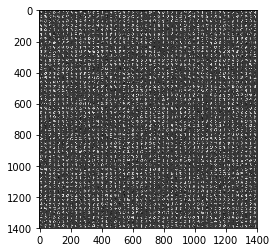

In [30]:
ResultImgShow(decodeImg_test_simple, model_name_simple, strImgLabel = "AFTER")

In [31]:
x_test_noise = DataRecovery(x_test_noise)
x_train_org  = DataRecovery(x_train_org)

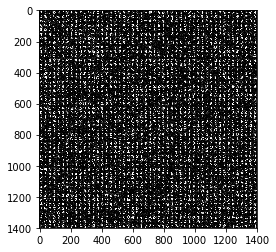

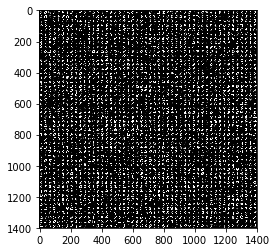

In [32]:
ResultImgShow(x_test_noise, model_name_simple, strImgLabel = "BEFORE")
ResultImgShow(x_train_org,  model_name_simple, strImgLabel = "ORIGIN")

### 計算結果

In [33]:
PSNR_ALL(decodeImg_test_simple, x_train_org, strImgLabel = "TEST");
SSIM_ALL(decodeImg_test_simple, x_train_org, strImgLabel = "TEST");

TEST PSNR: 15.44346577429805
TEST SSIM: 0.23716896719357228


###### 運行時間

In [34]:
_endTime = time.time()
print("It cost", _endTime - _startTime, "sec.")

It cost 1557.4696316719055 sec.
